<a href="https://colab.research.google.com/github/Zaxis018/efficientnet_object_detection/blob/main/object_detector_from_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install imutils

[INFO] looping over pyramid/windows took 0.13844 seconds
Total images 62.00


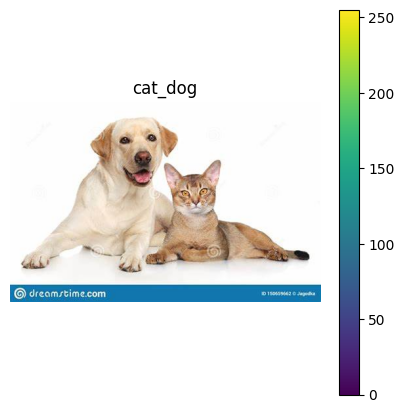

In [2]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.transforms.functional as F
import numpy as np
import cv2
import matplotlib.pyplot as plt
import imutils
from imutils.object_detection import non_max_suppression
import time
import imutils
import numpy as np
import cv2
import matplotlib.pyplot as plt
import argparse
import tensorflow as tf
import imutils
from imutils.object_detection import non_max_suppression


# Assuming you have a PyTorch model saved in 'your_model.pth'
model = torch.load('efficientnetv2.pth')
model.eval()

# Other imports remain the same
ap = argparse.ArgumentParser()
ap.add_argument("-i", "--image", default = "./cat_dog.jpg", #required=False,
    help="path to the input image")
ap.add_argument("-s", "--size", type=str, default="(200, 150)",
    help="ROI size (in pixels)")
ap.add_argument("-c", "--min-conf", type=float, default=0.7,
    help="minimum probability to filter weak detections")
ap.add_argument("-v", "--visualize", type=int, default=1,
    help="whether or not to show extra visualizations for debugging")
args = vars(ap.parse_args([]))

# Function to convert image from OpenCV format to PyTorch tensor
def cv2_to_tensor(image):
    image = F.to_tensor(image)
    image = F.normalize(image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    return image.unsqueeze(0)

image = cv2.imread(args["image"])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display image
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
ax.set_title("cat_dog")
plt.imshow(image)
plt.axis("off")
plt.colorbar()

# Other code remains the same until the loading of the model

WIDTH = 600 #
PYR_SCALE = 1.5
WIN_STEP = 16*3 # running on laptop so I generated a small pyramid
ROI_SIZE = eval(args["size"])
INPUT_SIZE = (224, 224) # input of resnet model.summary()


def image_pyramid(image, scale=1.5, minSize=(224, 224)):
    # yield the original image, this is the base of the image pyramid
    yield image
    # keep looping over the image pyramid
    while True:
        # compute the dimensions of the next image in the pyramid
        #scale controls how much the image is resized at each layer
        w = int(image.shape[1] / scale)
        # resize the image and take care of image aspect-ratio
        image = imutils.resize(image, width=w)
        # if the resized image does not meet the supplied minimum
        # size, then stop constructing the pyramid
        if image.shape[0] < minSize[1] or image.shape[1] < minSize[0]:
            break
        # yield the next image in the pyramid
        yield image

orig = image
orig = imutils.resize(orig, width=WIDTH)
(H, W) = orig.shape[:2]

pyramid = image_pyramid(orig, scale=PYR_SCALE, minSize=ROI_SIZE)
rois = []
locs = []
start = time.time()
tot_images = 0

# Convert sliding_window function to PyTorch equivalent
def sliding_window_pytorch(image, step, ws):
    for y in range(0, image.shape[0] - ws[1], step):
        for x in range(0, image.shape[1] - ws[0], step):
            yield (x, y, image[y:y + ws[1], x:x + ws[0]])

for p, image in enumerate(pyramid):
    scale = W / float(image.shape[1])
    sw = 0
    for (x, y, roiOrig) in sliding_window_pytorch(image, WIN_STEP, ROI_SIZE):
        sw += 1
        x = int(x * scale)
        y = int(y * scale)
        w = int(ROI_SIZE[0] * scale)
        h = int(ROI_SIZE[1] * scale)

        roi = cv2.resize(roiOrig, INPUT_SIZE)
        roi = cv2_to_tensor(roi)

        rois.append(roi)
        locs.append((x, y, x + w, y + h))

        if args["visualize"] > 0:
            clone = orig.copy()
            cv2.rectangle(clone, (x, y), (x + w, y + h), (0, 255, 0), 5)
            tot_images += 1

end = time.time()
print("[INFO] looping over pyramid/windows took {:.5f} seconds".format(end - start))
print("Total images {:.2f}".format(tot_images))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

rois = torch.cat(rois, dim=0)
with torch.no_grad():
    rois = rois.to(device)  # Assuming you have a GPU
    my_preds = model(rois)

# Other code remains the same until the end


In [6]:
# Move the tensor to CPU, then convert to NumPy array
rois = rois.cpu().numpy()

rois = np.array(rois, dtype="float32")
# classify each of the proposal ROIs using ResNet and then show how
# long the classifications took
print("[INFO] classifying ROIs...")
start = time.time()
# Assuming `model` is your PyTorch model and `rois` is your input data
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Temporarily turn off gradient descent
    rois = torch.from_numpy(rois)  # Convert the NumPy array to a PyTorch tensor
    rois = rois.to(device)  # Move the tensor to the device where the model is
    my_preds = model(rois)  # Make predictions

end = time.time()
print("[INFO] classifying ROIs took {:.5f} seconds".format(end - start))

[INFO] classifying ROIs...
[INFO] classifying ROIs took 0.03294 seconds


In [2]:
import imutils
import numpy as np
import cv2
import matplotlib.pyplot as plt
import argparse
import tensorflow as tf
import imutils
from imutils.object_detection import non_max_suppression
import time

In [3]:
ap = argparse.ArgumentParser()
ap.add_argument("-i", "--image", default = "./cat_dog.jpg", #required=False,
    help="path to the input image")
ap.add_argument("-s", "--size", type=str, default="(200, 150)",
    help="ROI size (in pixels)")
ap.add_argument("-c", "--min-conf", type=float, default=0.7,
    help="minimum probability to filter weak detections")
ap.add_argument("-v", "--visualize", type=int, default=1,
    help="whether or not to show extra visualizations for debugging")
args = vars(ap.parse_args([]))


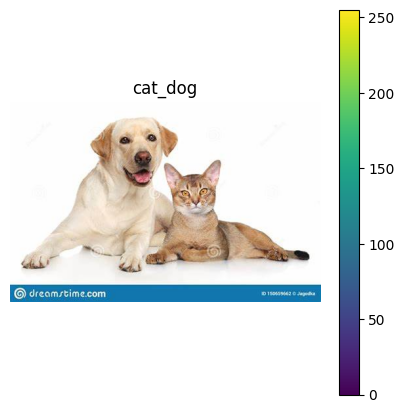

In [4]:
image = cv2.imread(args["image"])
#print(image.shape)
# resize image keeping aspect ratio
#r = 224 / image.shape[1] # ratio of new width /old width
#dim = (224, int(image.shape[0] * r)) # resized height
#image = cv2.resize(image, dim)
# move to RGB map
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# display image
fig = plt.figure(figsize = (5, 5))
ax = fig.add_subplot(111)
ax.set_title("cat_dog")
plt.imshow(image)
plt.axis("off")
plt.colorbar()

In [5]:
def sliding_window(image, step, ws):
    #slide a window of ws size over the image
    for y in range(0, image.shape[0]-ws[1], step): # rows-wise loop
        # -ws[1] avoids extending the sliding window outside the image itself, increment the y-position with step
        for x in range(0, image.shape[1] - ws[0], step):#columns-wise loop, increment the x-position with step
            # use yield(instead of return) because this is a generator
            #yield the actual x and y positions and the current window
            yield (x, y, image[y:y + ws[1], x:x + ws[0]])

In [6]:
def image_pyramid(image, scale=1.5, minSize=(224, 224)):
    # yield the original image, this is the base of the image pyramid
    yield image
    # keep looping over the image pyramid
    while True:
        # compute the dimensions of the next image in the pyramid
        #scale controls how much the image is resized at each layer
        w = int(image.shape[1] / scale)
        # resize the image and take care of image aspect-ratio
        image = imutils.resize(image, width=w)
        # if the resized image does not meet the supplied minimum
        # size, then stop constructing the pyramid
        if image.shape[0] < minSize[1] or image.shape[1] < minSize[0]:
            break
        # yield the next image in the pyramid
        yield image

In [7]:
WIDTH = 600 #
PYR_SCALE = 1.5
WIN_STEP = 16*3 # running on laptop so I generated a small pyramid
ROI_SIZE = eval(args["size"])
INPUT_SIZE = (224, 224) # input of resnet model.summary()

In [32]:
print("[INFO] loading network...")
model = tf.keras.applications.resnet.ResNet50(weights = "imagenet", include_top = "True")
print("...Done")

[INFO] loading network...
...Done


In [33]:
orig = image
orig = imutils.resize(orig, width = WIDTH)
(H, W) = orig.shape[:2] # 800, 600

In [34]:
pyramid = image_pyramid(orig, scale=PYR_SCALE, minSize=ROI_SIZE)
# initialize two lists, one to hold the ROIs generated from the image pyramid
#and sliding window, and another list used to store the
# (x, y)-coordinates of where the ROI was in the original image
rois = []
locs = []
# time how long it takes to loop over the image pyramid layers and
# sliding window locations
start = time.time()
counter = 0
tot_images = 0
for p, image in enumerate(pyramid):
    # determine the scale factor between the *original* image
    # dimensions and the *current* layer of the pyramid
    scale = W / float(image.shape[1])
    # for each layer of the image pyramid, loop over the sliding
    # window locations
    sw = 0
    for (x, y, roiOrig) in sliding_window(image, WIN_STEP, ROI_SIZE):
        sw = sw + 1
        # scale the (x, y)-coordinates of the ROI with respect to the
        # *original* image dimensions
        x = int(x * scale)
        y = int(y * scale)
        w = int(ROI_SIZE[0] * scale)
        h = int(ROI_SIZE[1] * scale)
        # take the ROI and pre-process it so we can later classify
        # the region using Keras/TensorFlow
        roi = cv2.resize(roiOrig, INPUT_SIZE)
        roi = tf.keras.preprocessing.image.img_to_array(roi)
        roi = tf.keras.applications.resnet.preprocess_input(roi)
        #print(roiOrig.shape, roi.shape)
        # update our list of ROIs and associated coordinates
        rois.append(roi)
        locs.append((x, y, x + w, y + h))
        # check to see if we are visualizing each of the sliding
        # windows in the image pyramid
        if args["visualize"] > 0:
            # clone the original image and then draw a bounding box
            # surrounding the current region
            clone = orig.copy()
            cv2.rectangle(clone, (x, y), (x + w, y + h),(0, 255, 0), 5)
            # show the visualization and current ROI
            #plt.imshow(clone)
            #var_name = "p" + str(p)+"_" + "sw" + str(sw) + ".jpg"
            #plt.savefig("images/clone_"+ var_name)
            #plt.imshow(roiOrig)
            #plt.savefig("images/roiOrig_"+ var_name)
            #cv2.waitKey(0)
            tot_images = tot_images +1
print(roiOrig.shape, roi.shape)
# show how long it took to loop over the image pyramid layers and
# sliding window locations
end = time.time()
print("[INFO] looping over pyramid/windows took {:.5f} seconds".format(end - start))
print("Total images {:.2f}".format(tot_images))

(150, 200, 3) (224, 224, 3)
[INFO] looping over pyramid/windows took 0.03943 seconds
Total images 62.00


In [35]:
rois = np.array(rois, dtype="float32")
# classify each of the proposal ROIs using ResNet and then show how
# long the classifications took
print("[INFO] classifying ROIs...")
start = time.time()
my_preds = model.predict(rois)
end = time.time()
print("[INFO] classifying ROIs took {:.5f} seconds".format(end - start))

[INFO] classifying ROIs...
2/2 [==============================] - 14s 7s/step
[INFO] classifying ROIs took 21.73513 seconds


In [16]:
# Assuming `my_preds` is the output of your model
predicted_probs, predicted_indices = torch.max(my_preds, 1)

# Load the class labels used by the pre-trained model
with open('cifar_10_classes.txt') as f:
    class_labels = [line.strip() for line in f.readlines()]

# Map the predicted indices and probabilities to the class labels
predicted_classes = [[(str(i.item()), class_labels[i], prob.item())] for i, prob in zip(predicted_indices, predicted_probs)]

# Now `predicted_classes` is a list of lists, where each inner list contains a single tuple with the class ID, class label, and prediction probability


In [17]:
predicted_classes

[[('2', 'bird', 1.0609502792358398)],
 [('2', 'bird', 1.5443187952041626)],
 [('5', 'dog', 4.5345778465271)],
 [('5', 'dog', 6.713545322418213)],
 [('5', 'dog', 6.357455730438232)],
 [('2', 'bird', 1.3899439573287964)],
 [('2', 'bird', 1.8263273239135742)],
 [('2', 'bird', 0.5422700047492981)],
 [('2', 'bird', 0.6122561097145081)],
 [('2', 'bird', 1.7001910209655762)],
 [('2', 'bird', 3.667349338531494)],
 [('5', 'dog', 8.757732391357422)],
 [('5', 'dog', 9.777441024780273)],
 [('5', 'dog', 8.85568618774414)],
 [('0', 'airplane', 2.390721321105957)],
 [('0', 'airplane', 4.161452770233154)],
 [('2', 'bird', 2.6092469692230225)],
 [('0', 'airplane', 1.455863118171692)],
 [('2', 'bird', 2.8657636642456055)],
 [('3', 'cat', 3.983675241470337)],
 [('3', 'cat', 5.07171630859375)],
 [('5', 'dog', 5.926535129547119)],
 [('3', 'cat', 6.576442718505859)],
 [('3', 'cat', 5.434337615966797)],
 [('0', 'airplane', 2.7385430335998535)],
 [('2', 'bird', 2.6631064414978027)],
 [('2', 'bird', 1.19137322

In [18]:
# labels (keys) to any ROIs associated with that label (values)
#preds = tf.keras.applications.imagenet_utils.decode_predictions(my_preds, top=1)
labels = {}
#probs = {}
# loop over the predictions
for (i, p) in enumerate(predicted_classes):
    # grab the prediction information for the current ROI
    (imagenetID, label, prob) = p[0]

    # filter out weak detections by ensuring the predicted probability
    # is greater than the minimum probability
    if prob >= args["min_conf"]:
        # grab the bounding box associated with the prediction and
        # convert the coordinates
        box = locs[i]

        # grab the list of predictions for the label and add the
        # bounding box and probability to the list
        L = labels.get(label, [])
        L.append((box, prob))
        labels[label] = L

[INFO] showing results for 'bird'
[INFO] showing results for 'dog'
[INFO] showing results for 'airplane'
[INFO] showing results for 'cat'
[INFO] showing results for 'frog'


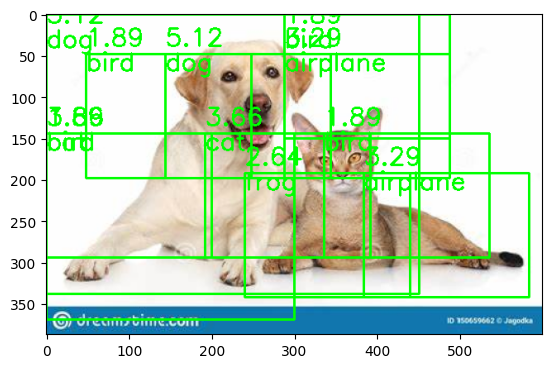

In [19]:
allclone = orig.copy()
for label in labels.keys():
    # clone the original image so that we can draw on it
    print("[INFO] showing results for '{}'".format(label))
    clone = orig.copy()

    # loop over all bounding boxes for the current label
    for (box, prob) in labels[label]:
        # draw the bounding box on the image
        (startX, startY, endX, endY) = box
        cv2.rectangle(clone, (startX, startY), (endX, endY),(0, 255, 0), 2)

    # show the results *before* applying non-maxima suppression, then
    # clone the image again so we can display the results *after*
    # applying non-maxima suppression
    #plt.imshow(clone)
    #cv2.imshow("Before", clone)
    clone = orig.copy()

    # extract the bounding boxes and associated prediction
    # probabilities, then apply non-maxima suppression
    boxes = np.array([p[0] for p in labels[label]])
    proba = np.array([p[1] for p in labels[label]])
    boxes = non_max_suppression(boxes, proba)

    # loop over all bounding boxes that were kept after applying
    # non-maxima suppression
    for (startX, startY, endX, endY) in boxes:
        # draw the bounding box and label on the image
        cv2.rectangle(clone, (startX, startY), (endX, endY),(0, 255, 0), 2)
        cv2.rectangle(allclone, (startX, startY), (endX, endY),(0, 255, 0), 2)
        y = startY - 10 if startY - 10 > 10 else startY + 10
        cv2.putText(clone, label, (startX, y+30),cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        cv2.putText(clone, "{:.2f}".format(prob), (startX, y),cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        cv2.putText(allclone, label, (startX, y+30),cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        cv2.putText(allclone, "{:.2f}".format(prob), (startX, y),cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    # show the output after apply non-maxima suppression
    plt.imshow(clone)
    plt.imsave("./detetcted" + label + ".jpg", clone)
plt.imshow(allclone)
plt.imsave("./detected.jpg", allclone)
    #plt.imshow(clone)
    #plt.imsave("images/_res03.jpg", clone)
    #cv2.imshow("After", clone)
    #cv2.waitKey(0)
